# The Poisson Regression Model

A step-by-step tutorial on how to create a Poisson regression model in Python using the GLM class of `statsmodels`, and how to train it on a real world data set.
<img src="../figs/nyc_bb_bicyclist_counts0a.png" alt="Alt text that describes the graphic" title="Python data types" style="width: 600px;"/><img src="../figs/nyc_bb_bicyclist_counts0b.png" alt="Alt text that describes the graphic" title="Python data types" style="width: 600px;"/>


Our goal is to build a Poisson regression model for the observed bicyclist counts y. We will use the trained model to predict daily counts of bicyclists on the Brooklyn bridge that the model has not seen during training.


<img src="../figs/nyc_bb_bicyclist_counts.png" alt="Alt text that describes the graphic" title="Python data types" style="width: 600px;"/> <img src="../figs/nyc_bb_bicyclist_counts2.png" alt="Alt text that describes the graphic" title="Python data types" style="width: 600px;"/>


## Summary of steps for performing Poisson Regression
In summary, here are the steps for performing a Poisson Regression on a count based data set:
1. First, make sure that your data set contains counts. One way to tell is that it contains only non-negative integer values that represent the number of occurrences of some event during some interval. In the bicyclist counts data set, it is the count of bicyclists crossing the Brooklyn bridge per day.
2. Find out (or guess) the regression variables that will influence the observed counts. In the bicyclist counts data set the regression variables are *Day of Week*, *Min Temp*, *Max Temp*, *Precipitation* etc.
3. Carve out a training data set that your regression model will train on, and a test data set that should keep aside. Do not train the model on the test data.
4. Use a suitable statistical software such as the Python `statsmodels` package to configure and fit the Poisson Regression model on the training data set.
5. Test the performance of the model by running it on the test data set so as to generate predicted counts. Compare them with the actual counts in the test data set.
6. Use a goodness-of-fit measure to determine how well your model has trained on the training data set.

In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
df

,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807
...,...,...,...,...
2017-10-27,62.1,48.0,0.00,3150
2017-10-28,68.0,55.9,0.00,2245
2017-10-29,64.9,61.0,3.03,183


Add a few derived regression variables to the $X$ matrix:

In [4]:
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day
df

,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-04-01,46.0,37.0,0.00,606,4,5,1
2017-04-02,62.1,41.0,0.00,2021,4,6,2
2017-04-03,63.0,50.0,0.03,2470,4,0,3
2017-04-04,51.1,46.0,1.18,723,4,1,4
2017-04-05,63.0,46.0,0.00,2807,4,2,5
...,...,...,...,...,...,...,...
2017-10-27,62.1,48.0,0.00,3150,10,4,27
2017-10-28,68.0,55.9,0.00,2245,10,5,28
2017-10-29,64.9,61.0,3.03,183,10,6,29


We will not use the Date variable as a regressor since it contains an absolute date value but we don't need to do anything special to drop Date as it is already consumed as the index of the pandas DataFrame. So it will not be available to us in the $X$ matrix.

Let's create the training and testing data sets.

In [6]:
mask = np.random.rand(len(df)) < 0.8   # pick 80% of random observation for training and the rest leave for testing
df_train = df[mask]
df_test = df[~mask]

print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=179
Testing data set length=35


Setup the regression expression in `patsy` notation. We are telling patsy that `BB_COUNT` is our dependent variable and it depends on the regression variables: `DAY`, `DAY_OF_WEEK`, `MONTH`, `HIGH_T`, `LOW_T` and `PRECIP`.

In [7]:
expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

Set up the $X$ and $y$ matrices for the training and testing data sets. $patsy$ makes this really simple:

In [8]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

Using the `statsmodels` GLM class, train the Poisson regression model on the training data set.

In [11]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
poisson_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               BB_COUNT   No. Observations:                  179
Model:                            GLM   Df Residuals:                      172
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13057.
Date:                Sun, 06 Mar 2022   Deviance:                       24390.
Time:                        22:03:12   Pearson chi2:                 2.41e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.0299      0.012    575.988      0.000       7.006       7.054
DAY             0.0003      0.000      1.897      0.058   -1.06e-05       0.001
DAY_OF_WEEK    -0.0215      0.001    -29.814      0.000      -0.023      -0.020
MONTH           0.0073      0.001      9.472      0.000       0.006       0.009
HIGH_T          0.0244      0.000     74.370      0.000       0.024       0.025
LOW_T          -0.0144      0.000    -40.352      0.000      -0.015      -0.014
PRECIP         -0.7900      0.007   -105.638      0.000      -0.805      -0.775
===============================================================================
"""

So how well did our model do? Let's make some **predictions** on the test data set.

In [14]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

                   mean    mean_se  mean_ci_lower  mean_ci_upper
Date                                                            
2017-04-02  2578.674724  14.033254    2551.316217    2606.326605
2017-04-22  1782.317817   8.318925    1766.087375    1798.697419
2017-05-09  2550.691919   8.843777    2533.417198    2568.084432
2017-05-11  2314.258844   7.333761    2299.929483    2328.677482
2017-05-20  2236.844492   7.499116    2222.194679    2251.590885
2017-05-24  2464.735287   7.031639    2450.991987    2478.555649
2017-06-01  3040.504644   9.613935    3021.719946    3059.406119
2017-06-05  2502.768327   9.811334    2483.612153    2522.072253
2017-06-08  2490.256288   6.906098    2476.757303    2503.828845
2017-06-11  3266.816669  12.331688    3242.736195    3291.075964
2017-06-17   804.204150   8.034652     788.609702     820.106973
2017-07-01  2503.446403  10.044847    2483.836075    2523.211558
2017-07-09  2792.845577   9.265221    2774.744988    2811.064242
2017-07-14  1759.857867  

Plot the predicted counts versus the actual counts for the test data:

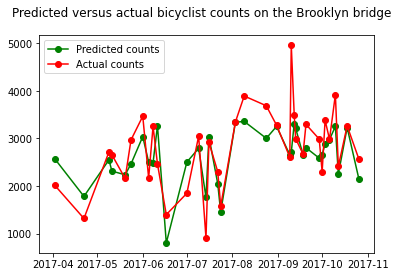

In [15]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']

fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

The model seems to be more or less tracking the trend in the actual counts although in many cases its predictions are way off the actual value.

Let's also plot Actual versus Predicted counts.

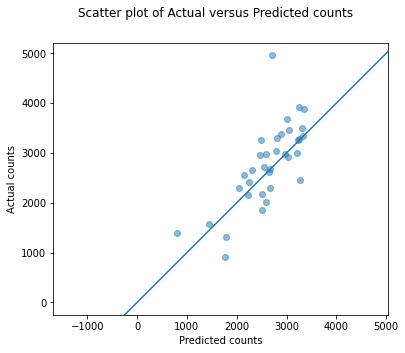

In [52]:
fig = plt.figure(figsize=(6,5))
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='o', alpha=0.5)
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')


plt.axline([0, 0], [1, 1]) # add a 45-degree line for reference
plt.axis('equal')
plt.set_ylim=(0, 5000)
plt.set_xlim=(0, 5000)

plt.show()